# Species Tree reconstruction

In this example we will try to obtain 4 different species tree for phylome 15.

1. Duptree
2. Concatenation
3. Astral-PRO
4. SpeciesRax

First of all to import the functions do:

In [1]:
import os
os.chdir("..")

In [2]:
import analyse_phylome as ap
from ete3 import Tree, PhyloTree

In [4]:
# set useful variable
duptreePath = ("/home/giacomo/master-thesis/Second_proj/obtain_phylome_data_scripts/duptree2")

outDir = "out_dir15"
treeFile = "test_data/best_trees15.txt"
duptreeFile = outDir + "/duptree_in.txt"
tagName = ""

ap.create_folder(outDir)

##### Duptree

Duptree is a super tree based method that has the advantage that it uses trees with duplications to infer the species tree that minimizes the number of inferred duplications according to reconciliation. It is one of the few programs you’ll find that returns a rooted tree. It will simpy need the best_trees file from PhylomeDB. 

obtain_duptree_file creates the input file for duptree. The gene-trees are simpy renamed with their species and you cand decide whether or not rooting them (midpoint=True)

In [ ]:
help(ap.obtain_duptree_file)

ap.obtain_duptree_file(treeFile, duptreeFile) #midpoint=True

help(ap.launch_duptree)

ap.launch_duptree(duptreeFile, "out_dir15/sp_duptree.nwk", duptreePath, outDir, tagName)


##### Concatenation tree

To do this, follow the tutorial in examples/example_cat.py and obtain the concat aln. Then, apply the phylomizer pipeline to this alignment. The alignment may be very long so it could be very computationally demanding.

The reconstruction pipeline is stored somewhere in /gpfs/projects/bsc40. -s t means that only the tree building step will be done.

`python reconstruction_pipeline.py -s t -i concat_aln -o out_tree`


#### Astral-PRO

"ASTRAL-Pro stands for ASTRAL for PaRalogs and Orthologs. ASTRAL is a tool for estimating an unrooted species tree given a set of unrooted gene trees and is statistically consistent under the multi-species coalescent model (and thus is useful for handling incomplete lineage sorting, i.e., ILS). ASTRAL-pro extends ASTRAL to allow multi-copy genes. ASTRAL-pro finds the species tree that has the maximum number of shared induced quartet tree equivalent classes with the set of gene trees, subject to the constraint that the set of bipartitions in the species tree comes from a predefined set of bipartitions." (see [here](https://github.com/chaoszhang/A-pro))

Though I suggest to use the C++ version of the tool which can be found [here](https://github.com/chaoszhang/ASTER/tree/548fd31493397ec44f5c8e3452c689e547b3e271) which is faster and can handle much larger jobs.

The function simply rename the trees with the species name as gene name.

In [ ]:
# simply rename the trees
ap.get_astral_pro_data(treeFile, "out_dir15/15_astral_trees.txt")

Once obtained the input trees to run astral-pro do:

`./astral_c/ASTER/astral-pro -o output_tree -u 1 -t threads best_trees_renamed.txt 2>&1 | tee apro.log`

Where -u stand for the level of verbosity. I suggest to redirect stdout to a logfile.

#### SpeciesRax

"SpeciesRax is part of the GeneRax tool and is available since GeneRax v2.0.0. SpeciesRax infers a rooted species tree from a set of unrooted gene trees." (see more [here](https://github.com/BenoitMorel/GeneRax)).

In order to run SpeciesRax need a family file where the tree file, the substition model and the mapping file between gene and species are explicited.

This function creates all of them. Note that to run SpeciesRax you don't need the alignment file.

In [ ]:
# speciesrax
ap.get_generax_data(treeFile, "out_dir15/sprax_15")

Then once obtained the data generax can be run in the cluster like this:

To load it

`module purge
module load gcc impi generax`


`mpiexec -np cores generax --families family.txt --strategy SKIP --si-strategy HYBRID --species-tree [MiniNJ or another species tre like duptree] --rec-model UndatedDTL --per-family-rates --prune-species-tree --si-estimate-bl --si-quartet-support --prefix sprax`

### Species Tree rooting

you can use the json file stored in phylomed db with sp2age dict for most phylomes in order to root the species tree with the furthest sequence. In some cases, the furthest species from spe2age may be distributed in non monopyletic clades, thus rooting will be meaningless. In those cases the user may decide to do midpoint rooting `midpoint=True` or do specify a list of outgroups.

In [5]:
import json

with open('data/root_phy.json') as f:
    all_dicts = json.load(f)
    
phy_id = '15'
spe2age_stored = all_dicts[phy_id]

In [6]:
sptree_file = "./test_data/phylome_15_sp_duptree.txt"
sptree = Tree(sptree_file)
# sptree_rooted = ap.root_tree(sptree, spe2age_stored)
print(sptree)


                     /-SCLSC
                  /-|
                 |   \-BLUGR
               /-|
              |  |   /-GIBZE
              |   \-|
              |     |   /-NEUCR
              |      \-|
            /-|         \-SORMK
           |  |
           |  |      /-MYCGR
           |  |   /-|
           |  |  |   \-PHANO
           |   \-|
         /-|     |   /-COCIM
        |  |      \-|
        |  |        |   /-EMENI
        |  |         \-|
        |  |            \-NEOFI
        |  |
        |  |   /-ARTOA
      /-|   \-|
     |  |     |   /-TUBMM
     |  |      \-|
     |  |        |   /-341454
     |  |         \-|
     |  |            \-PYROM
   /-|  |
  |  |  |   /-YARLI
  |  |   \-|
  |  |      \-YEAST
  |  |
--|  |   /-SCHPO
  |   \-|
  |      \-TAPDE
  |
  |   /-AGABI
   \-|
      \-LACBI


In [7]:
rooted_sptree = ap.root_species_tree(sptree, spe2age_stored)
# Alterntively, you could set specific outgroups by passing a list:
# rooted_sptree = ap.root_species_tree(sptree, out_list=['NEUCR','PHANO'])
# or decide to midpoint root
# rooted_sptree = ap.root_species_tree(sptree, midpoint=True)
print(rooted_sptree)

there are more than one furthest sequence, the root will be the ancestor node that comprise all of them.
['AGABI', 'LACBI']

      /-AGABI
   /-|
  |   \-LACBI
  |
  |                  /-SCLSC
  |               /-|
  |              |   \-BLUGR
  |            /-|
  |           |  |   /-GIBZE
  |           |   \-|
  |           |     |   /-NEUCR
  |           |      \-|
  |         /-|         \-SORMK
  |        |  |
  |        |  |      /-MYCGR
  |        |  |   /-|
--|        |  |  |   \-PHANO
  |        |   \-|
  |      /-|     |   /-COCIM
  |     |  |      \-|
  |     |  |        |   /-EMENI
  |     |  |         \-|
  |     |  |            \-NEOFI
  |     |  |
  |     |  |   /-ARTOA
  |   /-|   \-|
  |  |  |     |   /-TUBMM
  |  |  |      \-|
  |  |  |        |   /-341454
  |  |  |         \-|
  |  |  |            \-PYROM
   \-|  |
     |  |   /-YARLI
     |   \-|
     |      \-YEAST
     |
     |   /-SCHPO
      \-|
         \-TAPDE


### Species tree Visualization

In order to visualize the species tree we want to traslate the mnemonic code to NCBI taxonomic id. To do this we can download the uniprot dataframe where mnemonic codes are transleted with:

`curl https://www.uniprot.org/docs/speclist.txt -o data/speclist_$(date +'%d_%m_%y').txt`

Or you can use phylome info file to get the dictionary.

In [10]:
speclist = "./data/speclist_24_08_21.txt"
phy_info = "./data/phylome_info15.txt"

In [13]:
tax_dict_u = ap.get_tax_dict_uniprot(rooted_sptree, speclist)
print(tax_dict_u)
# or with phylome_info
tax_dict_i = ap.get_tax_dict_info(phy_info)
print(tax_dict_i)

You may want to add it manually
{'AGABI': '5341', 'ARTOA': '756982', 'BLUGR': '34373', 'COCIM': '246410', 'EMENI': '227321', 'GIBZE': '229533', 'LACBI': '29883', 'NEOFI': '331117', 'NEUCR': '367110', 'PHANO': '321614', 'PYROM': '1076935', 'SCHPO': '284812', 'SCLSC': '5180', 'SORMK': '771870', 'TAPDE': '1097556', 'TUBMM': '656061', 'YARLI': '284591', 'YEAST': '559292', '341454': '341454'}
{'YEAST': '4932', 'YARLI': '4952', 'NEUCR': '5141', 'SCLSC': '5180', 'AGABI': '5341', 'COCIM': '5501', 'GIBZE': '5518', 'LACBI': '29883', 'BLUGR': '34373', 'EMENI': '162425', 'SCHPO': '284812', 'PHANO': '321614', 'NEOFI': '331117', '341454': '341454', 'TUBMM': '656061', 'ARTOA': '756982', 'SORMK': '771870', 'MYCGR': '1047171', 'PYROM': '1076935', 'TAPDE': '1097556'}


if a species is missing you'll be warned and you can add the voice manually searching in ncbi taxonomy and do:

`tax_dict["MYCGR"] = '1047171'`

Anyway, the missing keys will still be handled in the visualization.

In [30]:
out_sptree = ap.get_taxonomic_df(tax_dict_i, rooted_sptree)
ap.viz_species_tree(out_sptree, show=False, render="./out_dir15/plot_suptree.png")

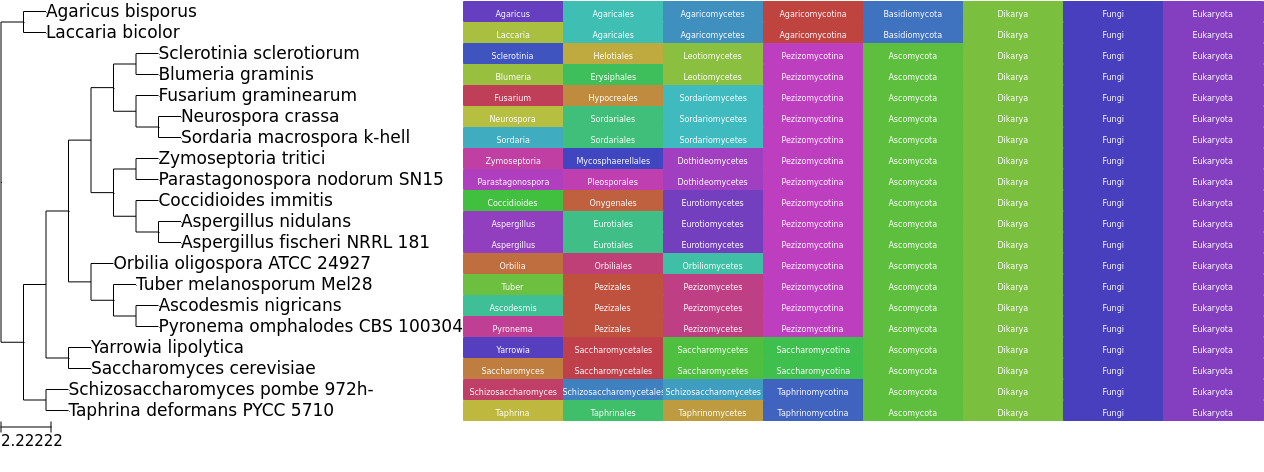

In [31]:
from IPython.display import Image
Image(filename='./out_dir15/plot_suptree.png') 